In [10]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d

import scipy.fftpack as fft
from scipy import ndimage

import numexpr as ne

from matplotlib.cm import get_cmap

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [11]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input(HMF_CHOICE='Yung')
CosmoParams_use,ClassyCosmo_use, CorrFclass_21_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)
AstroParams_use = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = False,)

ZMIN = 5.0 #down to which z we compute the evolution
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)

CoeffStructure_21_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)
PS21_use = zeus21.Power_Spectra(CosmoParams_use, AstroParams_use, ClassyCosmo_use, CorrFclass_21_use, CoeffStructure_21_use, RSD_MODE = RSDMODE)

In [12]:
def exponentialcorrelation(gamma1, gamma2, sigmaR1, sigmaR2, xi12):

    #note that it's in units of sigmaR (gamma 1 and 2 are for deltaR1 and deltaR2, gammaNL is the second-order correction)

    g1, g2 = gamma1*sigmaR1, gamma2*sigmaR2

    xi = xi12/(sigmaR1 * sigmaR2)# dimless, -1 to 1. 

    numerator = g1*g2 * xi 

    return np.exp(numerator)-1.0


def nonlinearcorrelation(gamma1, gamma1NL, gamma2, gamma2NL, sigmaR1, sigmaR2, xi12):

    #note that it's in units of sigmaR (gamma 1 and 2 are for deltaR1 and deltaR2, gammaNL is the second-order correction)

    g1, g1NL = gamma1*sigmaR1, gamma1NL*sigmaR1**2

    g2, g2NL = gamma2*sigmaR2, gamma2NL*sigmaR2**2

    xi = xi12/(sigmaR1 * sigmaR2)# dimless, -1 to 1. 


    denominator = 1 - 2*g1NL - 2 * g2NL + 4*g1NL*g2NL*(1-xi**2) 

    numerator = g1*g2 * xi + g1**2*(0.5-g2NL*(1-xi**2)) + g2**2*(0.5-g1NL*(1-xi**2))


    norm1 = np.exp(g1**2/(2.0-4.0*g1NL))/np.sqrt(1.0-2.0*g1NL)

    norm2 = np.exp(g2**2/(2.0-4.0*g2NL))/np.sqrt(1.0-2.0*g2NL)

    return np.exp(numerator/denominator)/np.sqrt(denominator)/norm1/norm2-1.0



In [13]:
# define redshift 
zGreaterMatrix100 = np.copy(CoeffStructure_21_use.zGreaterMatrix)
zGreaterMatrix100[np.isnan(zGreaterMatrix100)] = 100

# define radius below which non linear correction is introduced
_iRnonlinear = np.arange(CosmoParams_use.indexmaxNL)

In [14]:
# growth factor, matrices for R1 and R2

growthRmatrix = zeus21.cosmology.growth(CosmoParams_use,zGreaterMatrix100[:, _iRnonlinear])

growthRmatrix1 = growthRmatrix.reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
growthRmatrix2 = growthRmatrix.reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)

growth_corr = growthRmatrix1 * growthRmatrix2

In [15]:
# linear coeff
gammaR1 = (CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear]).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
gammaR2 = (CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear]).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear),1,1)

# quadratic coeff
gammaR1_NL = (CoeffStructure_21_use.gamma2_II_index2D[:, _iRnonlinear]).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1) 
gammaR2_NL = (CoeffStructure_21_use.gamma2_II_index2D[:, _iRnonlinear]).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear),1,1) 


In [16]:
# 2pt corr at z = 0 
corrdNL = CorrFclass_21_use.xi_RR_CF[np.ix_(_iRnonlinear,_iRnonlinear)]

# 2pt corr at z 
xi12 = corrdNL * growth_corr

In [17]:
# sigma values
sigmaR1 = (CoeffStructure_21_use.sigmaofRtab[:, _iRnonlinear]).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1) 
sigmaR2 = (CoeffStructure_21_use.sigmaofRtab[:, _iRnonlinear]).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear),1,1) 

In [18]:
lin = exponentialcorrelation(gammaR1, gammaR2, sigmaR1, sigmaR2, xi12)
quad = nonlinearcorrelation(gammaR1, gammaR1_NL, gammaR2, gammaR2_NL, sigmaR1, sigmaR2, xi12)

In [19]:
g1 = (gammaR1*sigmaR1).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
g2 = (gammaR1*sigmaR1).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)
gammamatrixR1R1 = g1 * g2

g1NL = (gammaR1_NL*sigmaR1**2).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
g2NL = (gammaR1_NL*sigmaR1**2).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)

corrdNL_gs = ne.evaluate('corrdNL * growth_corr')

gammaTimesCorrdNL = ne.evaluate('gammamatrixR1R1 * corrdNL_gs/ (sigmaR1*sigmaR2)')

numerator_NL = ne.evaluate('gammaTimesCorrdNL + g1 * g1 * (0.5 - g2NL * (1 - corrdNL_gs * corrdNL_gs)) + g2 * g2 * (0.5 - g1NL * (1 - corrdNL_gs * corrdNL_gs))')

denominator_NL = ne.evaluate('1 - 2 * g1NL - 2 * g2NL + 4 * g1NL * g2NL * (1 - corrdNL_gs * corrdNL_gs)')

norm1 = ne.evaluate('exp(g1 * g1 / (2 - 4 * g1NL)) / sqrt(1 - 2 * g1NL)') 
norm2 = ne.evaluate('exp(g2 * g2 / (2 - 4 * g2NL)) / sqrt(1 - 2 * g2NL)') 

linearcorrelation = ne.evaluate('exp(gammaTimesCorrdNL)')

log_norm = np.log(np.sqrt(denominator_NL) * norm1 * norm2)
nonlinearcorrelation = ne.evaluate('exp(numerator_NL/denominator_NL - log_norm)')

correction = ne.evaluate('(1 + numerator_NL/denominator_NL - log_norm) ')#/ sqrt(denominator_NL) / norm1 / norm2')

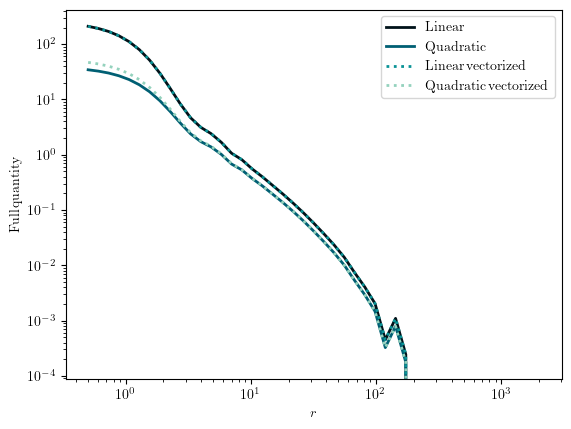

In [21]:
plt.loglog(CoeffStructure_21_use.Rtabsmoo,lin[-1,0,0],'-',label=r'$\rm Linear$')
plt.loglog(CoeffStructure_21_use.Rtabsmoo,quad[-1,0,0],'-',label=r'$\rm Quadratic$')
plt.loglog(CoeffStructure_21_use.Rtabsmoo,linearcorrelation[-1,0,0]-1,':',label=r'$\rm Linear\,vectorized$')
plt.loglog(CoeffStructure_21_use.Rtabsmoo,nonlinearcorrelation[-1,0,0]-1,':',label=r'$\rm Quadratic\,vectorized$')
plt.xlabel(r'$r$')
plt.ylabel(r'$\rm Full\, quantity$')
plt.legend()

$\frac{\exp^{N/D}}{\sqrt{D}N_1N_2}-\frac{1 + N/D}{\sqrt{D}N_1N_2}$

$\exp^{\gamma_1\gamma_2\xi}-1-\gamma_1\gamma_2\xi$

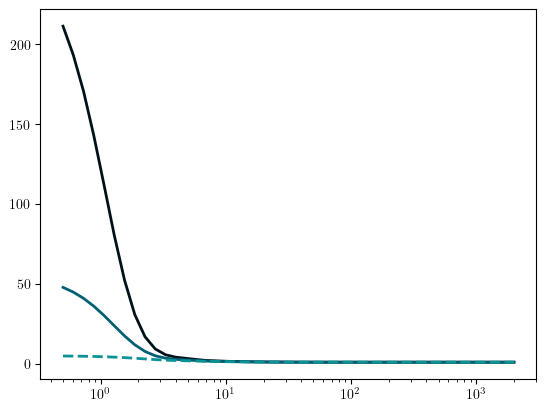

In [23]:
plt.semilogx(CoeffStructure_21_use.Rtabsmoo,linearcorrelation[-1,0,0],'-',label=r'$\rm Lin$')
#plt.semilogx(CoeffStructure_21_use.Rtabsmoo,(gammaTimesCorrdNL)[0,0,0],'-',label=r'$\rm Lin$')
#plt.semilogx(CoeffStructure_21_use.Rtabsmoo,((numerator_NL/denominator_NL))[0,0,0],':',label=r'$\rm Lin$')
plt.semilogx(CoeffStructure_21_use.Rtabsmoo,nonlinearcorrelation[-1,0,0],'-',label=r'$\rm Non-lin$')
plt.semilogx(CoeffStructure_21_use.Rtabsmoo,correction[-1,0,0],'--',label=r'$\rm Non-lin$')
#plt.semilogx(CoeffStructure_21_use.Rtabsmoo,((1+numerator_NL/denominator_NL)/np.sqrt(denominator_NL)/norm1/norm2)[0,0,0],'--',label=r'$\rm Test$')
#plt.ylim(-1,10)

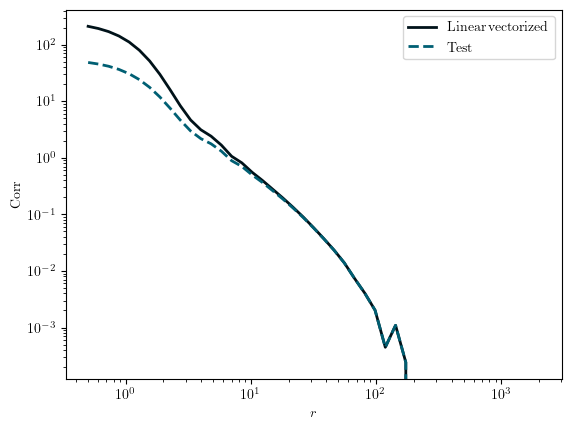

In [30]:
plt.loglog(CoeffStructure_21_use.Rtabsmoo,linearcorrelation[-1,0,0]-1-gammaTimesCorrdNL[-1,0,0]+gammaTimesCorrdNL[-1,0,0],'-',label=r'$\rm Linear\,vectorized$')
#plt.loglog(CoeffStructure_21_use.Rtabsmoo,(nonlinearcorrelation[0,0,0]-1-gammaTimesCorrdNL[0,0,0]),'-',label=r'$\rm Quadratic\,vectorized$')
plt.loglog(CoeffStructure_21_use.Rtabsmoo,(nonlinearcorrelation[-1,0,0]-correction)[-1,0,0]+gammaTimesCorrdNL[-1,0,0],'--',label=r'$\rm Test$')
plt.xlabel(r'$r$')
plt.ylabel(r'$\rm Corr$')
plt.legend()

Text(0, 0.5, '${\\rm SFRD}(\\delta_{4\\,{\\rm Mpc}}|z =6)/\\bar{\\rm SFRD}$')

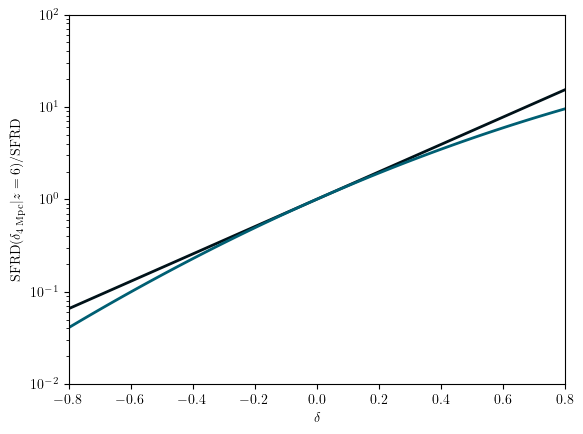

In [9]:
Nsigmad = 4.0 #how many sigmas we explore
Nds = 100 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)[np.newaxis,np.newaxis,:]

_iRnonlinear = np.arange(CosmoParams_use.indexmaxNL)

deltaArray = deltatab_norm * CoeffStructure_21_use.sigmaofRtab[:, _iRnonlinear,np.newaxis] 

tildedelta = deltaArray - CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear,np.newaxis] * CoeffStructure_21_use.sigmaofRtab[:, _iRnonlinear,np.newaxis]**2 / 2.

SFRD_lin = np.exp(CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear,np.newaxis] *deltaArray )
SFRD_quad = np.exp(CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear,np.newaxis] *deltaArray + CoeffStructure_21_use.gamma2_II_index2D[:, _iRnonlinear,np.newaxis] *deltaArray**2)

plt.semilogy(deltaArray[10,11],SFRD_lin[10,11])
plt.semilogy(deltaArray[10,11],SFRD_quad[10,11])

#plt.semilogy(deltaArray[10,11], SFRD_full[10,11]/SFRD_full[10,11,1],'--')

plt.xlim(-0.8,0.8)
plt.ylim(1e-2,1e2)
plt.xlabel(r'$\delta$')
plt.ylabel(r'${\rm SFRD}(\delta_{4\,{\rm Mpc}}|z =6)/\bar{\rm SFRD}$')